In [128]:
%run "0. config.ipynb"

https://api.redmetrics.io/v1/event.csv?game=0fe53936-027f-461c-b087-b5b5737b2163&gameVersion=51b8a78a-8dd3-4a5e-9f41-01e6805e0f52&entityType=event
48516


# data preparation

In [152]:
players_stats = df_raw.loc[:, ["playerId"]]

players_stats = players_stats.set_index([ "playerId"] )

# intitialisation des colonnes
list_types = list(df_raw.type.unique())

for type_name in list_types:
  players_stats[type_name] = 0

# elle sent la connerie cette boucle...
for i, s in players_stats.iterrows():
#for i, s in players_stats[0:20].iterrows():
  for t in list_types:
    count = int(df_raw[ (df_raw.playerId == i) & (df_raw.type == t ) ].loc[:, ["type"] ].count())
    players_stats.loc[i, t] = count # this will be way faster if we insert rows instead of cells...

# this line proves that there is something rotten with for-loop insertion
players_stats = players_stats.drop_duplicates()
    
#players_stats[players_stats.type.unique()] = 0
players_stats.head(10)

,start,selectmenu,reach,death,pickup,equip,craft,unequip,complete,switch,restart,gotourl,configure,gotomooc
playerId,,,,,,,,,,,,,,
9c183209-8867-46bb-9d29-9dda57e5a7bd,1,1,0,0,0,0,0,0,0,0,0,0,0,0
5af5f837-2aa1-4d5e-86a3-05d39d6cf63d,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3607b3ec-9e2a-4043-9f07-8dbccee66cb3,0,1,8,6,3,3,1,1,1,0,0,0,0,0
ff1cdcfc-9cfe-4b77-8562-3111808000e7,0,1,1,0,0,0,0,0,0,1,0,0,0,0
85de8fbc-b510-47c6-bfcd-ce829712c379,1,5,9,3,1,1,0,0,0,1,0,0,0,0
9fe9e95b-aa85-4a11-a73e-5d460f26e8a2,1,1,8,6,3,2,1,0,1,0,0,0,0,0
b3bfaf2a-9b35-4f53-9909-885d45d19e3a,1,1,9,6,3,3,1,0,0,0,0,0,0,0
0be21833-f660-4b7e-9ce5-fc5acf981d8f,0,1,3,3,1,1,0,0,0,0,0,0,0,0
8a398152-ff4a-4d35-9422-58aafdd7deab,1,2,0,0,0,0,0,0,0,0,1,0,0,0


In [216]:
players = df_raw.groupby("playerId").agg({ "serverTime": [ np.min, np.max  ] })

players["duration"] = pd.to_datetime(players["serverTime"]["amax"]) - pd.to_datetime(players["serverTime"]["amin"])

players["duration"] = players["duration"].map(lambda x: np.timedelta64(x, 's'))

players = players.loc[:, [("duration", "")]]

temp = pd.merge(players_stats, players, left_index=True, right_index=True)

# mais non y a pas de problème
temp = temp.rename(columns={("duration", "") : "duration (seconds)"})

temp["duration (seconds)"] = temp["duration (seconds)"].astype(int)/1000000000

players_stats = temp

In [217]:
players_stats.to_csv("data/players_stats.csv")

# PCA YOLO

In [113]:
from sklearn.decomposition import PCA

In [218]:
players_stats.mean()

start                   0.511364
selectmenu              1.784091
reach                   5.375000
death                   6.636364
pickup                  1.636364
equip                   2.136364
craft                   0.500000
unequip                 0.625000
complete                0.250000
switch                  0.306818
restart                 0.022727
gotourl                 0.113636
configure               0.329545
gotomooc                0.011364
duration (seconds)    831.159091
dtype: float64

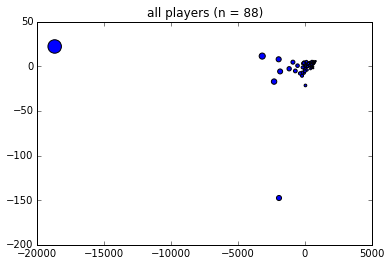

In [228]:
X = players_stats.as_matrix()
n = X.shape[0]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

d = 20 * players_stats["duration (seconds)"] / players_stats["duration (seconds)"].std()

plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], s= d) #, c=c, label=target_name)
plt.title("all players (n = %s)" % (n))
plt.legend()


we skipped gotomooc because there is no enough data


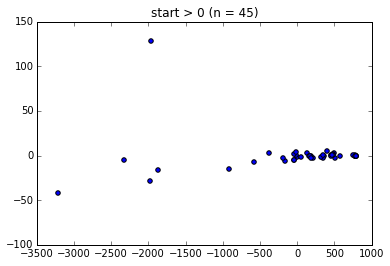

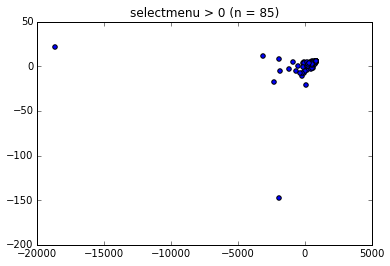

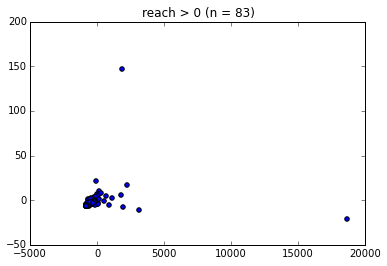

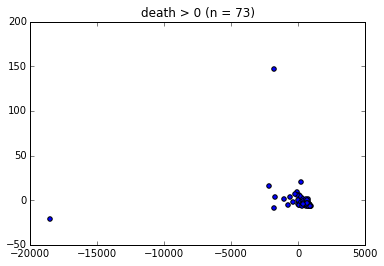

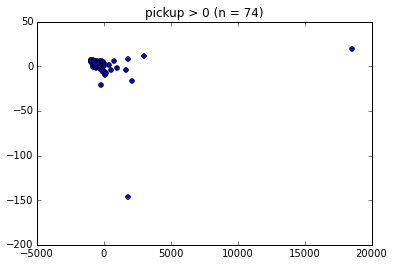

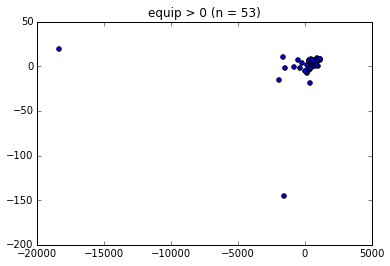

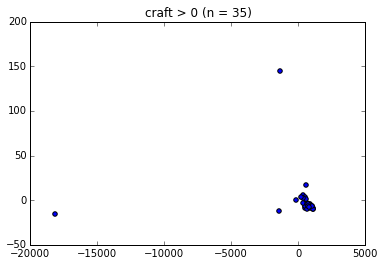

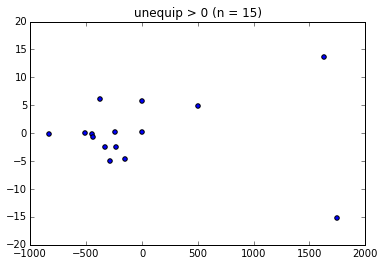

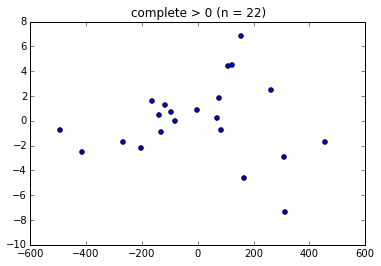

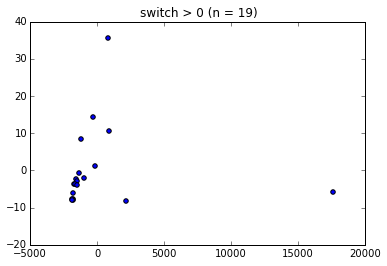

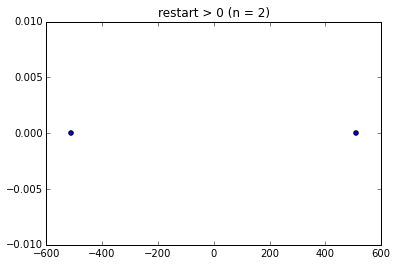

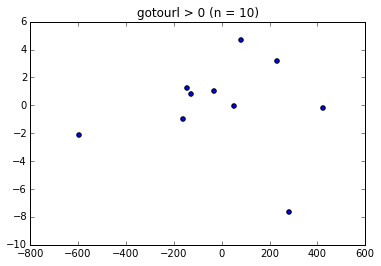

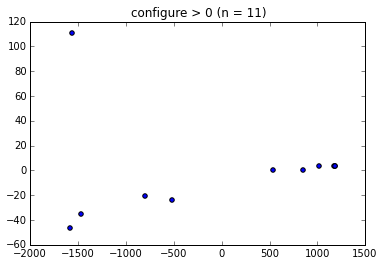

In [220]:
for title in list_types:
  df = players_stats[ players_stats[title] > 0 ] 
  
  X = df.as_matrix()
  n = X.shape[0]
  
  # print X
  # print n
  
  if n > 1:
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)

    d = 20 * df["duration (seconds)"] / df["duration (seconds)"].std()
    
    plt.figure()
    plt.scatter(X_r[:, 0], X_r[:, 1]) #, c=c, label=target_name)
    plt.title("%s > 0 (n = %s)" % (title, n))
    plt.legend()
  else:
    print "we skipped %s because there is no enough data" % title

plt.show();